#Xenon-135 precursor chain Numerical Solver with Fission-Gas Stripping

This numerical solver code is used to simulate the Xenon-Iodine system of equations that
dominates the fission product neutron poison concentration in the fuel of an operating nuclear reactor.

This is an object oriented program, allowing each method under class-Nuclide to operate on each nuclide in the decay chain (namely $^{135}Xe$ and $^{135}I$). The methods in this class represent each term of the system of DiffEQs. The timestep method calls each previous method to calculate the change in concentration based off of each term (generation or consumption), then applies arithmetic to calculate the total time-rate-of-change ($\frac{dNi}{dt}$)

###Clear variables from workspace

In [276]:
%reset -f

###Importing the necessary packages

numpy for arrays

matplotlib.pyplot for plotting

tqdm for progress bars (the time loops in this code take dozens of seconds and progress bars made with tqdm are much more visually appealing than manual print statements etc.)

In [277]:

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm
from copy import copy

##Set Up the framework for the simulation

###Define a global class that defines the constants needed to describe the core as well as gives the ability (through class methods) to modify conditions, e.g. simulate a scram or power transient

In [278]:
class Core: #Defining constants and allowing parameter changing (e.g. scram or power transient)
    #Constants
    tau = 130 #sec // flow period of molten salt
    sigma_F = 1e-24*180 #cm-2 
    gamma = {'I':0.0639,'Xe':0.00237} #dictionaries are used to assign constants to instances of class Nuclide
    lamda = {'I':2.87e-5, 'Xe':2.09e-5} #sec^-1
    sigma = {'I':0,   'Xe':1e-24*4.3e5} #cm^2 
    H = {'I':None,'Xe':1e-4} #c_g/c_l

    #FUEL... 18mol% HALEU-UF4 in FLiNaK @ 19.75% enrichment
    mole = 0.18
    enrichment = 0.1975 
    Avo = 6.0221408e23
    mass_den = 3.60510 #g/cm3 @915K
    MW = 35.555
    N = Avo*mass_den/MW #atoms/cm3
    basis = 5*mole+2*(1-mole)
    molefrac235 = mole/basis*enrichment
    print(f'{molefrac235} molefrac U235')
    Sigma_F = sigma_F*N*molefrac235 #cm-1
    
    #Parameters (initial)
    flux = 1e14 #n/cm2/s 
    FissionRate = Sigma_F*flux #cm-3.s
    print(f'Fission Rate: {FissionRate} cm-3.s')
    PowerDensity = FissionRate*200 #MeV/cm3.s
    Volume = 4.29116E5 #cm3
    Power = PowerDensity*Volume*1.6022e-13 #W
    print(f'{np.sum(Power*1e-6)} MegaWatts')
    
    #Start-up Conditions
    phi = flux
    Vdot_ratio = 0
    check = False #A bool used to set up plotting

    #Parameters (after scram)
    @classmethod
    def scram(cls):
        cls.phi= 0 #np.zeros(cls.phi.size) #n/cm2/s
        cls.check = True
        cls.eqXe = Xenon.concentration[-1]
        cls.eqI = Iodine.concentration[-1]
        
    @classmethod
    def strip(cls,strip):
        cls.Vdot_ratio = strip

    @classmethod #This is a method used to place the vertical dashed line in the post scram plot
    def cross(cls):
        cls.check = False
    
    @classmethod
    def restart(cls):
        cls.phi = 1e14
        cls.Vdot_ratio = 0

0.013996062992125984 molefrac U235
Fission Rate: 15383173267978.293 cm-3.s
211.52775625629943 MegaWatts


###Define a class that serves as the framework for creating nuclide objects

In [279]:
class Nuclide: #used to create iodine and xenon objects
    nuclides=[]
    def __init__(self, element,daughter):
        #dunder-init creates an instance of the Nuclide Class and assigns it initial properties.
        self.gamma, self.lamda, self.sigma, self.H = Core.gamma[element], Core.lamda[element], Core.sigma[element], Core.H[element]
        self.daughter = daughter
        self.concentration = [0] #atoms/cm3
        self.fission=[0] #atoms/cm3.s
        self.beta=[0] #atoms/cm3.s
        self.capture=[0] #atoms/cm3.s
        self.precursor=[0] #atoms/cm3.s
        self.strip=[0]
        Nuclide.nuclides.append(self)

    def ddt_fission(self): #generation term directly from fission
        ddt_multigroup = self.gamma*Core.Sigma_F*Core.phi
        ddt = np.sum(ddt_multigroup)
        self.fission.append(ddt)
        return ddt

    def ddt_beta(self): #consumption term by beta decay -- generation term for beta daughter
        ddt = self.lamda*self.concentration[-1]
        self.beta.append(ddt)
        if self.daughter != None:
            self.daughter.precursor.append(ddt)
        return ddt

    def ddt_capture(self): #consumption term. atom species changed by radiative capture
        ddt_5group = self.concentration[-1]*self.sigma*Core.phi
        ddt = np.sum(ddt_5group)
        self.capture.append(ddt)
        return ddt

    def ddt_strip(self): #novel - my derivation of a ddt term for single stage equilibrim stripping
        try: #calculates nuclide concentration term when valid
            ddt = self.concentration[-1]/Core.tau/(self.H/Core.Vdot_ratio+1)
        except (ZeroDivisionError, TypeError): #excludes stripping for Iodine and when helium flow rate is zero for Xenon
            ddt = 0
        self.strip.append(ddt)
        return ddt

    def timestep(self): #calls each term specific method then sums them and appends it to the object.concentration array
        self.ddt_fission()
        self.ddt_beta()
        self.ddt_capture()
        self.ddt_strip()
        ddt = self.fission[-1]+self.precursor[-1]-self.beta[-1]-self.capture[-1]-self.strip[-1]
        new = self.concentration[-1] + ddt
        self.concentration.append(new)
        return ddt
    
    @classmethod
    def numpy(cls): #converts the concentration lists to numpy arrays for ease of plotting
        for nuclide in cls.nuclides:
            nuclide.concentration = N2C(np.array(nuclide.concentration))
            
    @classmethod
    def reset(cls):
        for nuclide in cls.nuclides:
            nuclide.concentration = [0] #atoms/cm3
            nuclide.fission=[0] #atoms/cm3.s
            nuclide.beta=[0] #atoms/cm3.s
            nuclide.capture=[0] #atoms/cm3.s
            nuclide.precursor=[0] #atoms/cm3.s
            nuclide.strip=[0]

###Define function that converts from number density (atoms/cm3) to molar concentration (millimol/m3)

In [280]:
def N2C(Ni):
    Ci = 1e6*Ni/(Core.Avo/1000)
    return Ci

###Define function that converts from number density (atoms/cm3) to reactivity 

In [281]:
def N2rho(N):
    nu = 2.43
    rho = (Xenon.sigma*N)/(nu*Core.Sigma_F)
    return rho

##Run the Simulation

###Instantiate Nuclide Objects and calculate expected equilibrium concentration

In [282]:
Xenon = Nuclide('Xe',None)
Iodine = Nuclide('I',Xenon)

infI = Iodine.gamma*np.sum(Core.FissionRate)/Iodine.lamda
infXe = (Iodine.gamma+Xenon.gamma)*np.sum(Core.FissionRate)/(Xenon.lamda+np.sum(Xenon.sigma*Core.phi))

print(f'Equilibrium Concentrations')
print(f'{N2C(infI)} millimol/m3 I-135')
print(f'{N2C(infXe)} millimol/m3 Xe-135')
print(f'Xenon is at {infXe/infI*100}% of the Iodine level')
print(f'Poison Reactivity: {round(N2rho(infXe)*100,2)}%')

print(f'Initial Scram Rates')
print(f'{N2C(-infI*Iodine.lamda)} millimol/m3-s I-135')
print(f'{N2C(infI*Iodine.lamda-infXe*Xenon.lamda)} millimol/m3-s Xe-135')

tmax = np.log(Xenon.lamda/Iodine.lamda**2*infXe/infI*(Iodine.lamda-Xenon.lamda)+Xenon.lamda/Iodine.lamda)/(Xenon.lamda-Iodine.lamda)

Xe_max = (infXe)*np.exp(-Xenon.lamda*tmax)+(infI)*(Iodine.lamda)/(Iodine.lamda-Xenon.lamda)*(np.exp(-Xenon.lamda*tmax)-np.exp(-Iodine.lamda*tmax))

print(f'Peak time: {round(1/3600*tmax,2)} hr')
print(f'Peak level: {N2C(Xe_max)} millimol/m3 Xe-135')
print(f'Peak Poison Reactivity: {round(N2rho(Xe_max)*100,2)}%')

Equilibrium Concentrations
56.874028056046036 millimol/m3 I-135
26.491779944496784 millimol/m3 Xe-135
Xenon is at 46.579749755706914% of the Iodine level
Poison Reactivity: 1.84%
Initial Scram Rates
-0.0016322846052085212 millimol/m3-s I-135
0.0010786064043685386 millimol/m3-s Xe-135
Peak time: 7.05 hr
Peak level: 37.698966502695825 millimol/m3 Xe-135
Peak Poison Reactivity: 2.61%


Loop Parameters

In [283]:
dt=1 #sec
begin = 0 #hours
scram = 100 #hours
peak =7 #hours
end = 165 #hours
time = np.arange(begin,end*3600+1,dt) #sec

###Simulate without stripper

In [284]:
Core.restart()
Nuclide.reset()
for t in tqdm(time):#tqdm produces the progress bar
    Iodine.timestep()
    Xenon.timestep()

    if t==scram*3600:
        Core.scram()
        

    if Core.check and Xenon.concentration[-1] < Core.eqXe:
        Core.cross()
        eqt=t
        
#convert to numpy arrays for ease of plotting
Nuclide.numpy()

print(f'Poison Reactivity: {round(N2rho(Core.eqXe)*100,2)}%')

Core.eqI,Core.eqXe = N2C(Core.eqI),N2C(Core.eqXe)

print(f'Equilibrium Concentrations')
print(f'{Core.eqI} millimol/m3 I-135')
print(f'{Core.eqXe} millimol/m3 Xe-135')


print(f'Xenon peak at {round(time[np.where(np.max(Xenon.concentration)==Xenon.concentration)[0]][0]/3600-scram,2)} hours since scram ')
print(f'Xenon peak: {np.max(Xenon.concentration)} millimol/m3 Xe-135')
print(f'Return to Equilibrium at {round(eqt/3600-scram,1)} hours since scram')



100%|██████████| 594001/594001 [00:24<00:00, 23824.89it/s]


Poison Reactivity: 1.84%
Equilibrium Concentrations
56.87217577644078 millimol/m3 I-135
26.490269707189828 millimol/m3 Xe-135
Xenon peak at 7.05 hours since scram 
Xenon peak: 37.69764471590089 millimol/m3 Xe-135
Return to Equilibrium at 19.5 hours since scram


###Plot Rise to Equilibrium

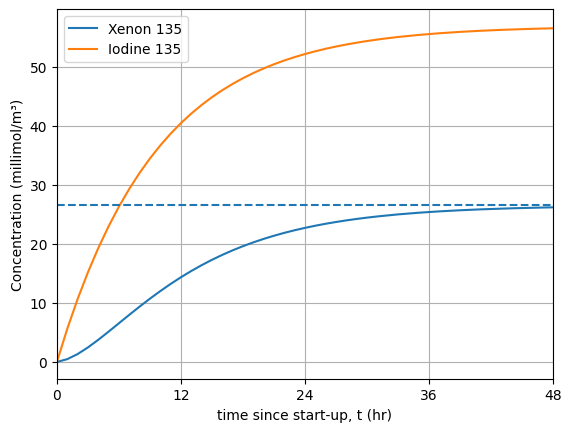

In [285]:
ax =  plt.gca()
plt.xlabel('time since start-up, t (hr)')
plt.ylabel(f'Concentration (millimol/m\N{SUPERSCRIPT THREE})')
plt.xlim(0,48)
plt.xticks([0,12,24,36,48])
plt.plot(time[::3600]/3600,Xenon.concentration[::3600],label='Xenon 135')
plt.plot(time[::3600]/3600,Iodine.concentration[::3600],label='Iodine 135')
plt.axhline(Core.eqXe,linestyle='--')
plt.grid()
plt.legend(loc='best')

plt.savefig('./img/start-up.png')

###Plot After Scram

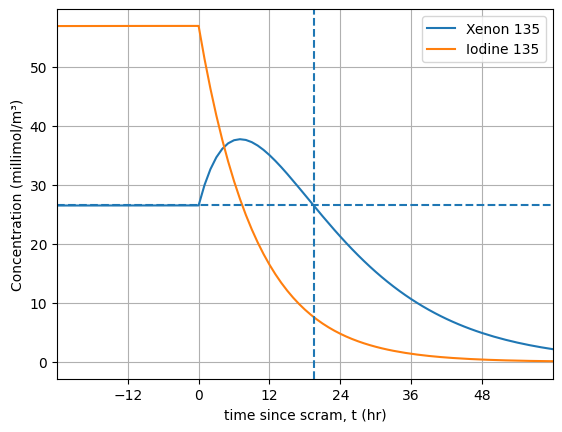

In [286]:
ax =  plt.gca()
plt.xlabel('time since scram, t (hr)')
plt.ylabel(f'Concentration (millimol/m\N{SUPERSCRIPT THREE})')
plt.xlim(-24,60)
plt.xticks([-12,0,12,24,36,48])
plt.plot(time[::3600]/3600-scram,Xenon.concentration[::3600],label='Xenon 135')
plt.plot(time[::3600]/3600-scram,Iodine.concentration[::3600],label='Iodine 135')
plt.axhline(Core.eqXe,linestyle='--')
plt.axvline(eqt/3600-scram,linestyle='--')
plt.grid()
plt.legend(loc='best')

plt.savefig('./img/noHe.png')

###Simulate Restart at Xenon peak

In [287]:
Core.restart()
Nuclide.reset()
for t in tqdm(time):#tqdm produces the progress bar
    Iodine.timestep()
    Xenon.timestep()

    if t==scram*3600:
        Core.scram()

    if Core.check and Xenon.concentration[-1] < Core.eqXe:
        Core.cross()
        eqt=t
        
    if t==(scram+peak)*3600:
        Core.restart()
        
#convert to numpy arrays for ease of plotting
rho_t = N2rho(np.array(Xenon.concentration))
Nuclide.numpy()

print(f'Poison Reactivity: {round(N2rho(Core.eqXe)*100,2)}%')

Core.eqI,Core.eqXe = N2C(Core.eqI),N2C(Core.eqXe)

print(f'Equilibrium Concentrations')
print(f'{Core.eqI} millimol/m3 I-135')
print(f'{Core.eqXe} millimol/m3 Xe-135')


print(f'Xenon peak at {round(time[np.where(np.max(Xenon.concentration)==Xenon.concentration)[0]][0]/3600-scram,2)} hours since scram ')
print(f'Xenon peak: {np.max(Xenon.concentration)} millimol/m3 Xe-135')
print(f'Return to Equilibrium at {round(eqt/3600-scram,1)} hours since scram')


100%|██████████| 594001/594001 [00:25<00:00, 23281.41it/s]


Poison Reactivity: 1.84%
Equilibrium Concentrations
56.87217577644078 millimol/m3 I-135
26.490269707189828 millimol/m3 Xe-135
Xenon peak at 7.0 hours since scram 
Xenon peak: 37.69728375774063 millimol/m3 Xe-135
Return to Equilibrium at 10.0 hours since scram


In [319]:
Core.restart()
Nuclide.reset()
for t in tqdm(time):#tqdm produces the progress bar
    Iodine.timestep()
    Xenon.timestep()

    if t==scram*3600:
        Core.scram()

    if Core.check and Xenon.concentration[-1] < Core.eqXe:
        Core.cross()
        eqt=t
        
    if t==(scram+peak)*3600:
        Core.restart()
        
#convert to numpy arrays for ease of plotting
rho_t = N2rho(np.array(Xenon.concentration))
Nuclide.numpy()

print(f'Poison Reactivity: {round(N2rho(Core.eqXe)*100,2)}%')

Core.eqI,Core.eqXe = N2C(Core.eqI),N2C(Core.eqXe)

print(f'Equilibrium Concentrations')
print(f'{Core.eqI} millimol/m3 I-135')
print(f'{Core.eqXe} millimol/m3 Xe-135')


print(f'Xenon peak at {round(time[np.where(np.max(Xenon.concentration)==Xenon.concentration)[0]][0]/3600-scram,2)} hours since scram ')
print(f'Xenon peak: {np.max(Xenon.concentration)} millimol/m3 Xe-135')
print(f'Return to Equilibrium at {round(eqt/3600-scram,1)} hours since scram')

100%|██████████| 594001/594001 [00:27<00:00, 21611.92it/s]


Poison Reactivity: 1.84%
Equilibrium Concentrations
56.87217577644078 millimol/m3 I-135
26.490269707189828 millimol/m3 Xe-135
Xenon peak at 7.0 hours since scram 
Xenon peak: 37.69728375774063 millimol/m3 Xe-135
Return to Equilibrium at 10.0 hours since scram


In [329]:
print(f'max build-up rate of {round(max(1e5*np.diff(rho_t[:3600*scram:3600])))} pcm/hr')
print(f'max burnout rate of {round(min(1e5*np.diff(rho_t[::3600])))} pcm/hr')
print(f'minimum overshoot of {round(100*min(rho_t[3600*scram:]),2)}% at {round(np.argmin(rho_t[3600*scram:])/3600-peak,1)} hours after restart')

max build-up rate of 99 pcm/hr
max burnout rate of -337 pcm/hr
minimum overshoot of 1.49% at 9.4 hours after restart


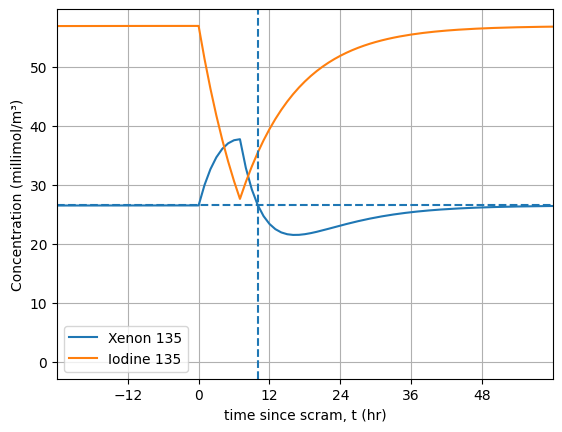

In [290]:
ax =  plt.gca()
plt.xlabel('time since scram, t (hr)')
plt.ylabel(f'Concentration (millimol/m\N{SUPERSCRIPT THREE})')
plt.xlim(-24,60)
plt.xticks([-12,0,12,24,36,48])
plt.plot(time[::3600]/3600-scram,Xenon.concentration[::3600],label='Xenon 135')
plt.plot(time[::3600]/3600-scram,Iodine.concentration[::3600],label='Iodine 135')
plt.axhline(Core.eqXe,linestyle='--')
plt.axvline(eqt/3600-scram,linestyle='--')
plt.grid()
plt.legend(loc='best')

plt.savefig('./img/peakrestart.png')
plt.show()

###Simulate with Stripper

In [291]:
Core.restart()
Nuclide.reset()
for t in tqdm(time):
    Iodine.timestep()
    Xenon.timestep()

    if t==scram*3600:
        Core.scram()
        Core.strip(2.35e-7)
        

    if Core.check and Xenon.concentration[-1] < Core.eqXe:
        Core.cross()
        eqt=t
        
#convert to numpy arrays for ease of plotting
Nuclide.numpy()
Core.eqXe = N2C(Core.eqXe)

print(f'Return to equilibrium at {round(eqt/3600-scram,1)} hours since scram)')

100%|██████████| 594001/594001 [00:28<00:00, 20575.91it/s]


Return to equilibrium at 8.0 hours since scram)


###Plot after Scram with Stripper

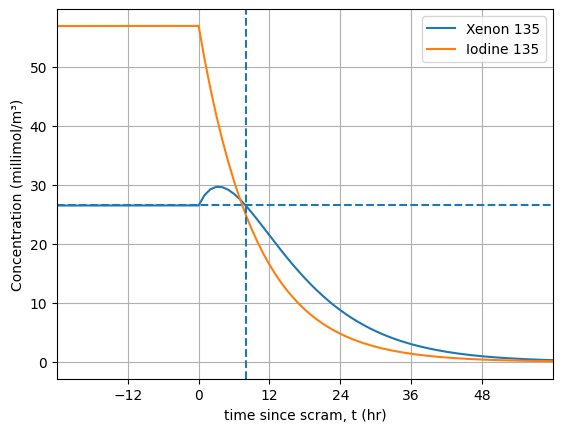

In [292]:
ax =  plt.gca()
plt.xlabel('time since scram, t (hr)')
plt.ylabel(f'Concentration (millimol/m\N{SUPERSCRIPT THREE})')
plt.xlim(-24,60)
plt.xticks([-12,0,12,24,36,48])
plt.plot(time[::3600]/3600-scram,Xenon.concentration[::3600],label='Xenon 135')
plt.plot(time[::3600]/3600-scram,Iodine.concentration[::3600],label='Iodine 135')
plt.axhline(Core.eqXe,linestyle='--')
plt.axvline(eqt/3600-scram,linestyle='--')
plt.grid()
plt.legend(loc='best')

plt.savefig('./img/8hr_restart.png')



###Simulate with Stripper (Standby)

In [293]:
Core.restart()
Nuclide.reset()
for t in tqdm(time):
    Iodine.timestep()
    Xenon.timestep()

    if t==scram*3600:
        Core.scram()
        
    if t==(scram+peak)*3600:
        Core.strip(2.1e-5)

    if Core.check and Xenon.concentration[-1] < Core.eqXe:
        Core.cross()
        eqt=t
        
#convert to numpy arrays for ease of plotting
Nuclide.numpy()
Core.eqXe = N2C(Core.eqXe)

print(f'Return to equilibrium at {round(eqt-(scram+peak)*3600,1)} seconds since call for power')

100%|██████████| 594001/594001 [00:26<00:00, 22263.01it/s]


Return to equilibrium at 265 seconds since call for power


###Standby Plot 

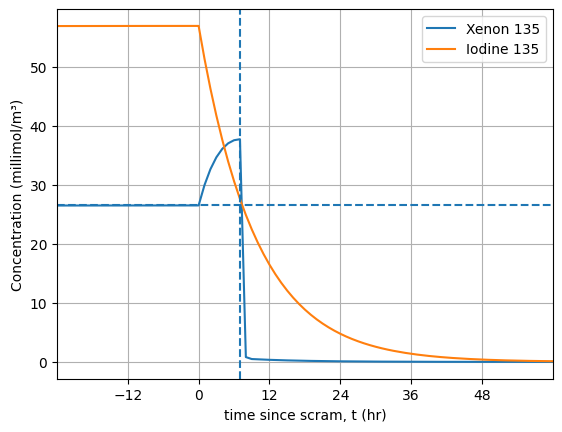

In [294]:
ax =  plt.gca()
plt.xlabel('time since scram, t (hr)')
plt.ylabel(f'Concentration (millimol/m\N{SUPERSCRIPT THREE})')
plt.xlim(-24,60)
plt.xticks([-12,0,12,24,36,48])
plt.plot(time[::3600]/3600-scram,Xenon.concentration[::3600],label='Xenon 135')
plt.plot(time[::3600]/3600-scram,Iodine.concentration[::3600],label='Iodine 135')
plt.axhline(Core.eqXe,linestyle='--')
plt.axvline(eqt/3600-scram,linestyle='--')
plt.grid()
plt.legend(loc='best')

plt.savefig('./img/standby_restart.png')


##Simulate EOL Fuel

In [295]:

Core.restart()
Nuclide.reset()
for t in tqdm(time):#tqdm produces the progress bar
    Iodine.timestep()
    Xenon.timestep()

    if t==0:
        Core.strip(1e-5)
    
    if t==scram*3600:
        Core.scram()
        Core.strip(0) 

    #if Core.check and Xenon.concentration[-1] < Core.eqXe:
        #Core.cross()
        #eqt=t
        
#convert to numpy arrays for ease of plotting
#Core.eqXe = Xenon.concentration[-1]
#Core.eqI = Iodine.concentration[-1]
Nuclide.numpy()

print(f'Poison Reactivity: {round(N2rho(Core.eqXe)*100,2)}%')

Core.eqI,Core.eqXe = N2C(Core.eqI),N2C(Core.eqXe)

print(f'Equilibrium Concentrations')
print(f'{Core.eqI} millimol/m3 I-135')
print(f'{Core.eqXe} millimol/m3 Xe-135')


100%|██████████| 594001/594001 [00:25<00:00, 23302.99it/s]


Poison Reactivity: 0.15%
Equilibrium Concentrations
56.87217577644078 millimol/m3 I-135
2.217987355594172 millimol/m3 Xe-135


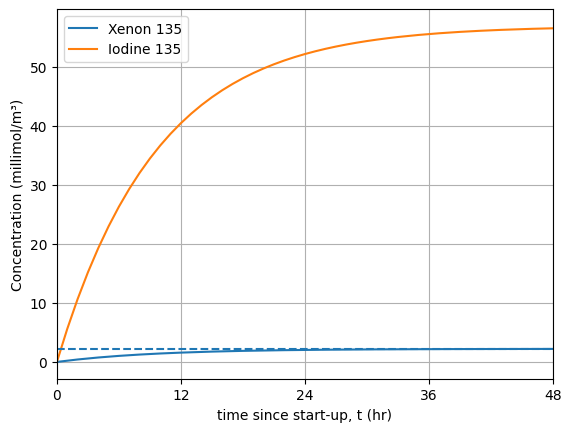

In [296]:
ax =  plt.gca()
plt.xlabel('time since start-up, t (hr)')
plt.ylabel(f'Concentration (millimol/m\N{SUPERSCRIPT THREE})')
plt.xlim(0,48)
plt.xticks([0,12,24,36,48])
plt.plot(time[::3600]/3600,Xenon.concentration[::3600],label='Xenon 135')
plt.plot(time[::3600]/3600,Iodine.concentration[::3600],label='Iodine 135')
plt.axhline(Core.eqXe,linestyle='--')
plt.grid()
plt.legend(loc='best')

plt.savefig('./img/EOL-startup.png')

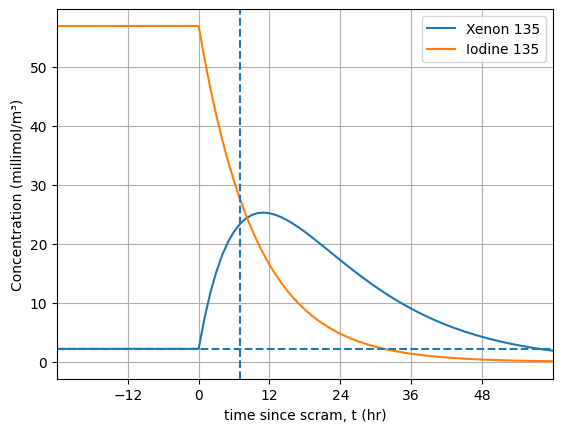

In [297]:
ax =  plt.gca()
plt.xlabel('time since scram, t (hr)')
plt.ylabel(f'Concentration (millimol/m\N{SUPERSCRIPT THREE})')
plt.xlim(-24,60)
plt.xticks([-12,0,12,24,36,48])
plt.plot(time[::3600]/3600-scram,Xenon.concentration[::3600],label='Xenon 135')
plt.plot(time[::3600]/3600-scram,Iodine.concentration[::3600],label='Iodine 135')
plt.axhline(Core.eqXe,linestyle='--')
plt.axvline(eqt/3600-scram,linestyle='--')
plt.grid()
plt.legend(loc='best')

plt.savefig('./img/EOL-scram.png')